In [12]:
import os
import pandas as pd
import configparser
#import mysql.connector
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

config = configparser.ConfigParser()
config.read('..\\config.ini')

host = config['mysql']['host']
database = config['mysql']['database']
user = config['mysql']['user']
password = config['mysql']['password']
port = config['mysql']['port']

In [2]:
def read_query(query):
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')
    df = pd.read_sql(query, con=engine)
    print('Query Executed!')
    return df

The goal of this project is to build a recommender system for a ecommerce website that reccommends products to users based on what they initially choose. Since, the dataset is intended to be used by general users, some of the features in customer table need to be ignored since they will not be available for a random user. So, since postal code is masked we can just remove it.

Dropping `postal code`

In [ ]:

remove_postal =""" 
    ALTER TABLE customers
    DROP COLUMN postal_code;
"""
# postal_code removed
read_query(remove_postal)

In [10]:
customers_data = """
    SELECT *
    FROM customers
    LIMIT 10;
"""

In [12]:
read_query(customers_data)

Query Executed!


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,None,None,NaN
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,NaN,NaN,ACTIVE,NONE,20.0
7,00007d2de826758b65a93dd24ce629ed66842531df6699...,1.0,1.0,ACTIVE,Regularly,32.0
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,NaN,ACTIVE,NONE,20.0
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,NaN,ACTIVE,NONE,20.0


`fashion_news_frequency` seem to have typos where it contains "None" and "NONE" and should just be considered empty. So before we proceed we will fix this: 

In [ ]:
fix_none_fashion = """
    SET SQL_SAFE_UPDATES = 0;
    UPDATE h_m_db.customers
    SET fashion_news_frequency = NULL
    WHERE fashion_news_frequency = 'NONE';
    SET SQL_SAFE_UPDATES = 1;
"""

read_query(fix_none_fashion)

In [31]:
read_query(customers_data)

Query Executed!


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,None,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,None,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,None,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,None,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,None,None,NaN
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,NaN,NaN,ACTIVE,None,20.0
7,00007d2de826758b65a93dd24ce629ed66842531df6699...,1.0,1.0,ACTIVE,Regularly,32.0
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,NaN,ACTIVE,None,20.0
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,NaN,ACTIVE,None,20.0


Now that postal codes are removed, we can first make sure `customer_id` is unique and then find customers who have all the features blank. 

In [14]:
customer_duplicate = """
    SELECT COUNT(*) as All_customers, COUNT(DISTINCT customer_id) as unique_customers
    FROM customers
"""

read_query(customer_duplicate)

Query Executed!


,All_customers,unique_customers
0,1371980,1371980


There are 1371980 customers in total with no duplicates.

Customers with all features blank:

In [33]:
blank_all = """
SELECT COUNT(customer_id) AS all_empty
FROM customers
WHERE FN IS NULL AND
    Active IS NULL AND
    club_member_status IS NULL AND
    fashion_news_frequency IS NULL AND
    age IS NULL 
"""

read_query(blank_all)

Query Executed!


,all_empty
0,2286


There are 2286 customers with no data at all which is $ \frac{2286}{1371980} \times 100 = 0.17 \% $ of our data so we can just remove those without losing too much information.

In [ ]:
delete_empty = """
SET SQL_SAFE_UPDATES = 0;
DELETE FROM h_m_db.customers
WHERE FN IS NULL AND
          Active IS NULL AND
          club_member_status IS NULL AND
          fashion_news_frequency IS NULL AND
          age IS NULL;
SET SQL_SAFE_UPDATES = 1;
"""

read_query(delete_empty)

In [36]:
# Checking
read_query(blank_all)

Query Executed!


,all_empty
0,0


How much of the `FN` feature is empty?

In [4]:
query_check = """
SELECT 
    COUNT(customer_id) AS TOTAL,
    (COUNT(customer_id) / 1371980) * 100 AS proportion
FROM
    h_m_db.customers
WHERE
    FN IS NULL;
"""

read_query(query_check)

Query Executed!


,TOTAL,proportion
0,892764,65.0712


65.07% of the entries for FN are empty. Similarly, we can now check for `fashion_news_frequency`:


In [5]:
query_check = """
SELECT 
    COUNT(customer_id) AS TOTAL,
    (COUNT(customer_id) / 1371980) * 100 AS proportion
FROM
    h_m_db.customers
WHERE
    fashion_news_frequency IS NULL;
"""

read_query(query_check)

Query Executed!


,TOTAL,proportion
0,891436,64.9744


64.97% of `fashion_news_frequency` is empty which is quite similar to `FN`.

Checking the other features now:

age:

In [6]:
query_check = """
SELECT 
    COUNT(customer_id) AS TOTAL,
    (COUNT(customer_id) / 1371980) * 100 AS proportion
FROM
    h_m_db.customers
WHERE
    age IS NULL;
"""

read_query(query_check)

Query Executed!


,TOTAL,proportion
0,13575,0.9894


`Active`:

In [7]:
query_check = """
SELECT 
    COUNT(customer_id) AS TOTAL,
    (COUNT(customer_id) / 1371980) * 100 AS proportion
FROM
    h_m_db.customers
WHERE
    Active IS NULL;
"""

read_query(query_check)

Query Executed!


,TOTAL,proportion
0,905290,65.9842


`club_member_status`:

In [8]:
query_check = """
SELECT 
    COUNT(customer_id) AS TOTAL,
    (COUNT(customer_id) / 1371980) * 100 AS proportion
FROM
    h_m_db.customers
WHERE
    club_member_status IS NULL;
"""

read_query(query_check)

Query Executed!


,TOTAL,proportion
0,3776,0.2752


Only `age` and `club_memeber_status` have few missing values whereas the rest of the features have ~65% of the values missing. For now we will proceed with just `age` and `club_memeber_status`and drop the other features.

New Table:

In [11]:
read_query(customers_data)

Query Executed!


,customer_id,club_member_status,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,ACTIVE,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,ACTIVE,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,ACTIVE,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,ACTIVE,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,ACTIVE,52.0
5,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,ACTIVE,20.0
6,00007d2de826758b65a93dd24ce629ed66842531df6699...,ACTIVE,32.0
7,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,ACTIVE,20.0
8,00008469a21b50b3d147c97135e25b4201a8c58997f787...,ACTIVE,20.0
9,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,ACTIVE,29.0


Checking the breakdown of club_member_status:

In [14]:
breakdown = """
SELECT 
    club_member_status, COUNT(*) as breakdown
FROM
    h_m_db.customers
WHERE
    club_member_status IS NOT NULL
group by club_member_status;
"""

break_df = read_query(breakdown)
break_df

Query Executed!


,club_member_status,breakdown
0,ACTIVE,1272491
1,PRE-CREATE,92960
2,LEFT CLUB,467


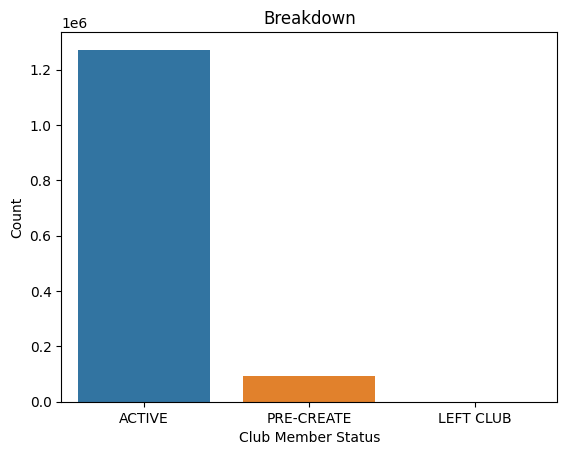

In [15]:
sns.barplot(x='club_member_status', y='breakdown', data=break_df)

plt.xlabel('Club Member Status')
plt.ylabel('Count')
plt.title('Breakdown')
plt.show()

Here we can see that almost all club member status is "Active". We can remove this feature too since this feature will not contribute much to the model's prediction as it doesnot have much variability.

In [ ]:
# drop club_member_status
query = """
ALTER TABLE h_m_db.customers
DROP COLUMN club_member_status;
"""

read_query(query)

Checking `age`:

In [17]:
age_df

,customer_id,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0
5,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,20.0
6,00007d2de826758b65a93dd24ce629ed66842531df6699...,32.0
7,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,20.0
8,00008469a21b50b3d147c97135e25b4201a8c58997f787...,20.0
9,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,29.0


Query Executed!


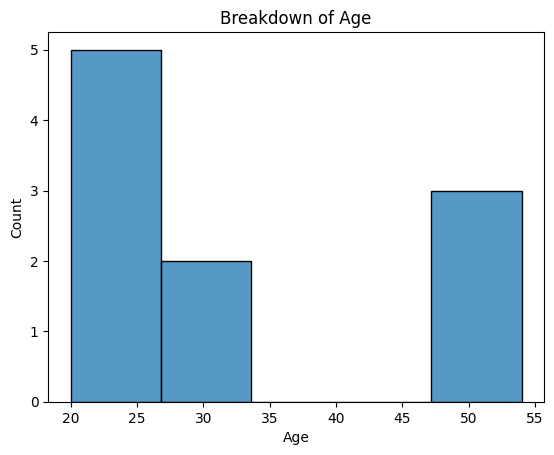

In [19]:
age_df = read_query(customers_data)

sns.histplot(x='age', data=age_df)

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Breakdown of Age')
plt.show()

The age of the customers can be seen to be broken into 3 groups with 20-27 age group containing the most customers. However, there seem to be not enough customers in the 34-45 age group. Therefore, we can use the individual age of a customer as customers who fall in the 34-45 group donot have any information for our model to train on. Instead, we can combine the age into groups rather than indivdual age. 

`Age-Groups`:

In [21]:
query = """
SELECT 
    customer_id,
    CASE
        WHEN age < 30 THEN 'less than 30'
        ELSE '30+'
    END AS age_group
FROM
    h_m_db.customers
WHERE
    age IS NOT NULL;
"""

group_df = read_query(query)

group_df.head(5)

Query Executed!


,customer_id,age_group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,30+
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,less than 30
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,less than 30
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,30+
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,30+


Checking the breakdown now:

In [22]:
query = """
SELECT 
    age_group, COUNT(*) AS breakdown
FROM
    (SELECT 
        customer_id,
            CASE
                WHEN age < 30 THEN 'less than 30'
                ELSE '30+'
            END AS age_group
    FROM
        h_m_db.customers
    WHERE
        age IS NOT NULL) AS A
group by A.age_group;
"""

break_age = read_query(query)

break_age

Query Executed!


,age_group,breakdown
0,30+,756178
1,less than 30,599941


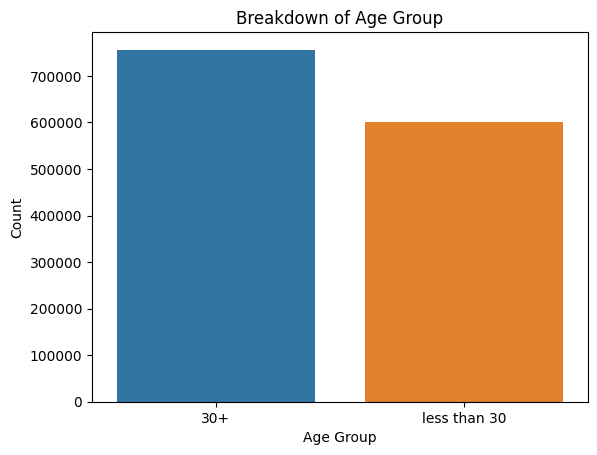

In [23]:
sns.barplot(x='age_group', y='breakdown', data=break_age)

plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Breakdown of Age Group')
plt.show()

Now the dataset is more balance and so we can finally use this in building our recommender system